In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f""

import numpy as np
import torch

%matplotlib inline
import matplotlib.pyplot as plt

from torchrf.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from torchrf.utils.channel import time_lag_discrete_time_channel, cir_to_time_channel
from torchrf.constants import SPEED_OF_LIGHT

In [7]:
ball_loc = np.array([0, 0, 10])
scene = load_scene("../src/torchrf/rt/scenes/c4/untitled.xml")

In [8]:
for i, obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name}")

elm__3 : itu_metal


In [9]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

tx_loc = np.array([45, 25, 5])
tx = Transmitter(name="tx", position=tx_loc.tolist(), orientation=[0, 0, 0])
scene.add(tx)

rx_loc = np.array([-45, 45, 2])
rx = Receiver(name="rx", position=rx_loc.tolist(), orientation=[0, 0, 0])
scene.add(rx)

In [10]:
bandwidth = 15e6
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [11]:
scene.get("elm__3").radio_material.scattering_coefficient = 0.5
paths = scene.compute_paths(max_depth=5,
                            diffraction=True,
                            scattering=True,
                            num_samples=5e6,
                            scat_keep_prob=0.1)  # Number of rays shot into directions defined

scene.preview(paths=paths, show_devices=True)


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

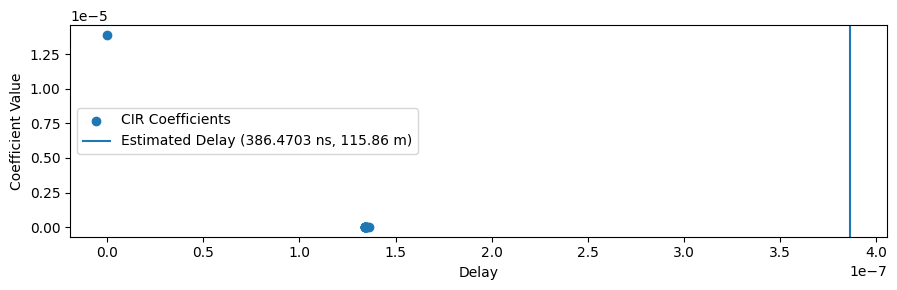

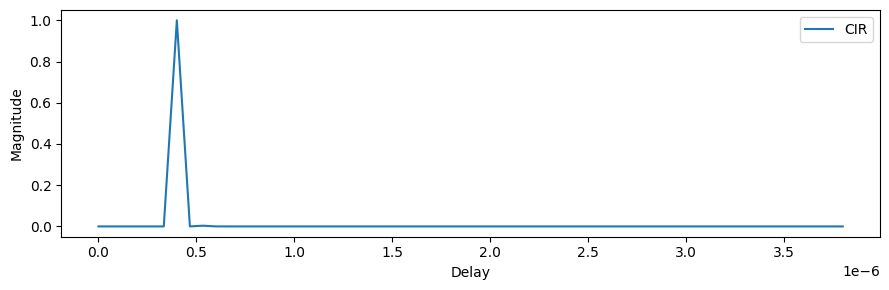

In [24]:
a, tau = paths.cir()
l_min, l_max = time_lag_discrete_time_channel(bandwidth)
h = cir_to_time_channel(bandwidth, a, tau, l_min, l_max, normalize=True)

est_dist = np.sqrt((np.sum((ball_loc - tx_loc)**2))) + np.sqrt(np.sum((ball_loc - rx_loc)**2))
est_delay = est_dist / SPEED_OF_LIGHT
fig, ax = plt.subplots(figsize=(9, 3))
ax.scatter(abs(tau.detach().numpy().flatten()), abs(a.detach().numpy().flatten()), label='CIR Coefficients')
ax.axvline(est_delay, label=f'Estimated Delay ({est_delay*1e9:.4f} ns, {est_dist:.2f} m)')
ax.set_ylabel("Coefficient Value")
ax.set_xlabel("Delay")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 3))
start, stop = 0, len(h.flatten())
# start, stop = 0, 100
ax.plot(np.arange(start, stop)/bandwidth, abs(h.detach().numpy().flatten())[start:stop], label='CIR')
ax.set_ylabel("Magnitude")
ax.set_xlabel("Delay")
ax.legend()
plt.tight_layout()
plt.show()

In [20]:
print(np.sqrt((np.sum((ball_loc - tx_loc)**2))))
print(np.sqrt(np.sum((ball_loc - rx_loc)**2)))
print(np.sqrt(np.sum((tx_loc - rx_loc)**2)))

print(np.sqrt(np.sum((ball_loc - rx_loc)**2)) + np.sqrt(np.sum((ball_loc - rx_loc)**2)) - np.sqrt(np.sum((tx_loc - rx_loc)**2)))


51.720402163943
64.1404708432983
92.24424101265076
36.036700673945845


In [ ]:
my_cam = Camera("my_cam", position=[10,0,300], look_at=[0,0,0])
my_cam.look_at([0,0,0])
scene.add(my_cam)

cm = scene.coverage_map(cm_cell_size=[1,1], num_samples=20e6, max_depth=5)
scene.render(my_cam, coverage_map=cm, cm_vmin=-200, cm_vmax=-90);